<a href="https://colab.research.google.com/github/dnaieleps/quakeAI/blob/main/quakeAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all necessary libraries

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
color_pallete = sns.color_palette()
print('COMPLETE')

COMPLETE


# Uploading the csv file and cleaning it up using pandas
Here, the dataset was cleaned to only include each earthquakes date, latitude, longitude, depth, magnitude, residual root-mean-square, and type. Each of the rows were evaluated on whether or not they were considered to be in the Ring of Fire, our area of interest. Additionally, each earthquake has calculated values that indicate when the last X.0+ magnitude earthquake occurred.

In [3]:
### mounting the csv data file from shared google drive to the google colab project ###
from datetime import datetime
from google.colab import drive
import pandas as pd
import numpy as np
import re
drive.mount('/content/drive')
df_full = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Significant_Earthquakes.csv') # earthquake data
plates = gpd.read_file('/content/drive/My Drive/Colab Notebooks/PB2002_plates.json') # fault line location data


### changing the time column to a preferred format ###
df_full['time'] = pd.to_datetime(df_full['time'])
df_full.sort_values('time', inplace=True)
df_full.reset_index(drop=True, inplace=True)


### computing custom features that would be useful to the model for training data ###
# computing time since last X.0+ magnitude earthquake for each earthquake event (tsl5-tsl9)
df_full = df_full.dropna(subset=['mag']) # remove rows without magnitude
thresholds = [5.0, 6.0, 7.0, 8.0, 9.0]
last_seen = {thr: None for thr in thresholds}
tsl_columns = {thr: [] for thr in thresholds}

for i, row in df_full.iterrows():
    current_time = row['time']
    current_mag = row['mag']

    for thr in thresholds:
        if last_seen[thr] is None:
            tsl_columns[thr].append(np.nan)
        else:
            delta = (current_time - last_seen[thr]).total_seconds() / 3600.0 # calculates the time since last X.0+ mag EQ and converts to hours
            tsl_columns[thr].append(delta)

    if pd.notna(current_mag):
        for thr in thresholds:
            if current_mag >= thr:
                last_seen[thr] = current_time

for thr in thresholds:
    df_full[f'tsl{int(thr)}'] = tsl_columns[thr]

# compute feature that stores the epicenter's distance from the ring of fire
df_full['distance'] = np.nan

ring_plates = ['Pacific', 'Nazca', 'Cocos', 'Philippine', 'Juan de Fuca'] # specify plates in the ring of fire
plates_ring = plates[plates['PlateName'].isin(ring_plates)]

eq_gdf = gpd.GeoDataFrame( # make dataframe consisting of fault line data
    df_full,
    geometry=gpd.points_from_xy(df_full.longitude, df_full.latitude),
    crs='EPSG:4326'
)
plates_proj = plates_ring.to_crs(epsg=3857)
eq_gdf = eq_gdf.to_crs(epsg=3857)
eq_gdf['distance'] = eq_gdf.geometry.apply(lambda point: plates_proj.distance(point).min() / 1000.0) # computes minimum distance to ring of fire faultline
df_full['distance'] = eq_gdf['distance']



### dropping all the unnecessary columns / duplicates / null values ###
df_filtered = df_full.copy()
df_filtered.drop(['magType', 'nst', 'gap', 'dmin', 'net', 'id', 'updated', 'horizontalError',
                  'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource'],
                 axis=1, inplace=True, errors='ignore')
valid_countries = ['Chile', 'Peru', 'Ecuador', 'Colombia', 'Panama', 'Costa Rica',
                   'Nicaragua', 'Honduras', 'El Salvador', 'Guatemala', 'Mexico', 'California',
                   'Oregon', 'Washington', 'Canada', 'Alaska', 'Russia', 'Japan', 'Korea', 'China',
                   'Taiwan', 'Philippines', 'Vietnam', 'Malaysia', 'Indonesia', 'Cambodia', 'Thailand',
                   'Laos', 'Papau New Guinea', 'Australia', 'New Zealand', 'Solomon Islands', 'New Caledonia',
                   'Fiji', 'Tonga', 'Cook Islands', 'Micronesia', 'Vanuatu', 'Samoa', 'Timor Leste',
                   'Norfolk Islands', 'New Caledonia', 'Nauru', 'Tuvalu', 'Marshall Islands', 'Guam',
                   'Bangladesh', 'India', 'Brunei', 'Singapore', 'Palau', 'Myanmar', 'Argentina',
                   'Belize', 'Haiti', 'Jamaica', 'Cuba', ' CA ', ' MX ']
pattern = '|'.join(re.escape(country) for country in valid_countries)
df_filtered['is_valid_country'] = df_filtered['place'].fillna('').str.contains(pattern, case=False, regex=True)
df_filtered = df_filtered[df_filtered['time'] >= '1982-01-01']
df_filtered = df_filtered[df_filtered['type'] == 'earthquake']
df_filtered = df_filtered[df_filtered['is_valid_country'] == True]
df_filtered = df_filtered.dropna(subset=['time', 'latitude', 'longitude', 'depth', 'mag', 'rms', 'tsl5', 'tsl6', 'tsl7', 'tsl8', 'tsl9', 'distance'])
df_filtered.drop(['place', 'type', 'is_valid_country'], axis=1, inplace=True)
df_filtered.drop_duplicates(inplace=True)
df_filtered.reset_index(drop=True, inplace=True)

# reorder columns and print info
df_filtered = df_filtered[['time', 'latitude', 'longitude', 'tsl5', 'tsl6', 'tsl7', 'tsl8', 'tsl9', 'distance', 'rms', 'depth', 'mag']]
df = df_filtered.copy()
df.info()
df.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52300 entries, 0 to 52299
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   time       52300 non-null  datetime64[ns, UTC]
 1   latitude   52300 non-null  float64            
 2   longitude  52300 non-null  float64            
 3   tsl5       52300 non-null  float64            
 4   tsl6       52300 non-null  float64            
 5   tsl7       52300 non-null  float64            
 6   tsl8       52300 non-null  float64            
 7   tsl9       52300 non-null  float64            
 8   distance   52300 non-null  float64            
 9   rms        52300 non-null  float64            
 10  depth      52300 non-null  float64            
 11  mag        52300 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(11)
memory usage: 4.8 MB


,time,latitude,longitude,tsl5,tsl6,tsl7,tsl8,tsl9,distance,rms,depth,mag
0,1982-01-01 10:53:07.460000+00:00,-17.954,-178.496,2.891436,113.231619,137.793039,38308.736653,155719.280961,301.265330,0.9,587.2,5.5
1,1982-01-01 18:51:01.560000+00:00,26.823,142.557,5.181061,121.196647,145.758067,38316.701681,155727.245989,78.017226,0.9,22.2,6.7
2,1982-01-02 03:30:56.240000+00:00,16.814,-100.246,8.665189,8.665189,154.423256,38325.366869,155735.911178,43.910285,1.1,26.3,5.2
3,1982-01-02 07:05:53.410000+00:00,16.778,-100.121,3.582547,12.247736,158.005803,38328.949417,155739.493725,44.040798,1.1,19.1,5.4
4,1982-01-03 17:41:56.960000+00:00,-25.515,-177.019,3.535142,3.535142,192.606789,38363.550403,155774.094711,184.144186,1.3,135.9,5.2


# Using matplotlib to examine relationships

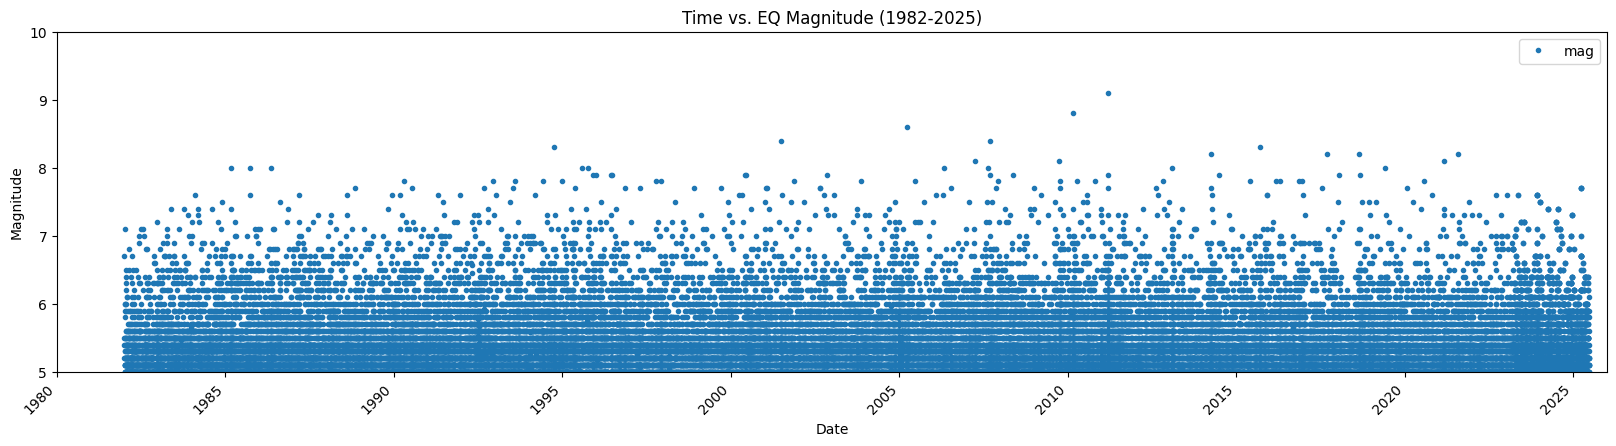

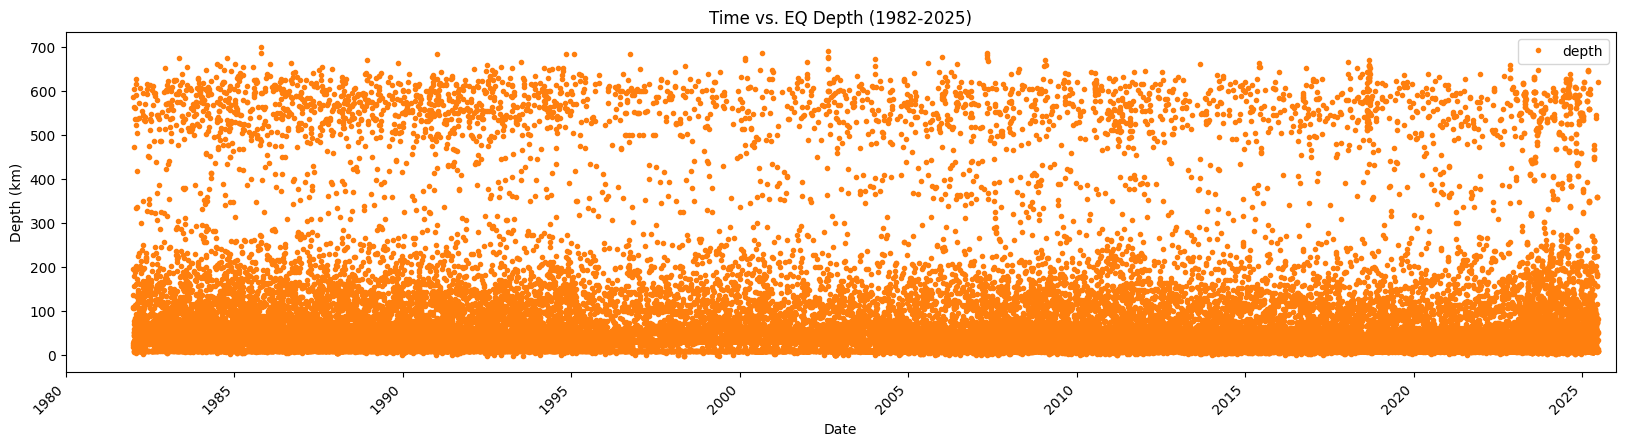

In [4]:
### PLOT FOR TIME VS MAGNITUDE ###
fig, ax1 = plt.subplots(figsize=(20, 5))
df.plot(
    style='.',
    figsize=(20, 5),
    color=color_pallete[0],
    x='time', y='mag',
    title='Time vs. EQ Magnitude (1982-2025)',
    ylabel="Magnitude", xlabel='Date',
    ax=ax1
)

# x-axis tweaking
tick_years = pd.date_range(start='1980', end='2026', freq='5YS')
ax1.set_xticks(tick_years)
ax1.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2025-12-31'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', labelrotation=45)

# y-axis tweaking
ax1.set_ylim(5, 10)

######################################################################

### PLOT FOR TIME VS DEPTH ###
fig, ax2 = plt.subplots(figsize=(20, 5))
df.plot(
    style='.',
    figsize=(20, 5),
    color=color_pallete[1],
    x='time', y='depth',
    title='Time vs. EQ Depth (1982-2025)',
    ylabel="Depth (km)", xlabel='Date',
    ax=ax2
)

# x-axis tweaking
tick_years = pd.date_range(start='1980', end='2026', freq='5YS')
ax2.set_xticks(tick_years)
ax2.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2025-12-31'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='x', labelrotation=45)

# Creating the training sets and building the model using tensorflow and numpy

In [5]:
df['time'] = df['time'].astype(int) # casting the datetime column to an int to be able to be made into an array

X = df.iloc[:, 0:10]
y = df.iloc[:, 10:]

# creating the training and test sets as np arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

eval_results = {}
print(X_train[0], y_train[0])

# constructing the xgb regression model, which uses a tree ensemble of xg boosted trees to predict the output
model = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    learning_rate=0.075,
    max_depth=4,
    reg_lambda=2,
    reg_alpha=0.5,
    gamma=1,
    min_child_weight=8,
)

# fitting the model to the training data and comparing the training loss and test loss side-by-side
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100
)

(41840, 10) (10460, 10) (41840, 2) (10460, 2)
[ 9.50223658e+17 -2.75820000e+01  6.57810000e+01  8.70451111e+00
  1.07451458e+02  7.98226931e+02  1.65078090e+04  3.14467412e+05
  9.12670072e+03  8.70000000e-01] [10.   5.3]
[0]	validation_0-rmse:89.59188	validation_1-rmse:87.70361
[100]	validation_0-rmse:43.51004	validation_1-rmse:44.59852
[200]	validation_0-rmse:36.85825	validation_1-rmse:38.63600
[300]	validation_0-rmse:34.09329	validation_1-rmse:36.47111
[400]	validation_0-rmse:32.24883	validation_1-rmse:35.25321
[500]	validation_0-rmse:31.08690	validation_1-rmse:34.57385
[600]	validation_0-rmse:30.13055	validation_1-rmse:33.97876
[700]	validation_0-rmse:29.19117	validation_1-rmse:33.43128
[800]	validation_0-rmse:28.34217	validation_1-rmse:33.00524
[900]	validation_0-rmse:27.75685	validation_1-rmse:32.75227
[999]	validation_0-rmse:27.14703	validation_1-rmse:32.37338


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.075, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Error analysis and evaluating feature importance
Here, each of the model's predictions is plotted against its actual values

Percentage of predictions within ±0.5 of the actual magnitude: 0.8923518164435946
Percentage of predictions within ±100 km of the actual depth: 0.960038240917782


/tmp/ipython-input-15-3679307067.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


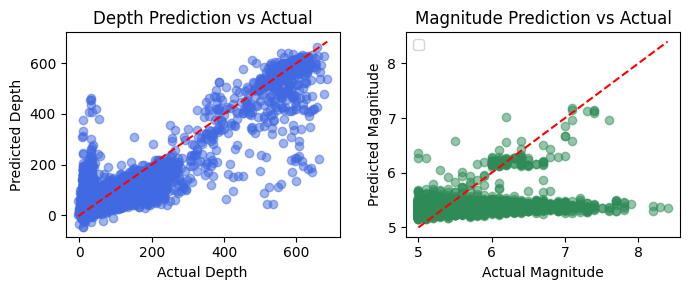

<Axes: title={'center': 'Feature Importance'}>

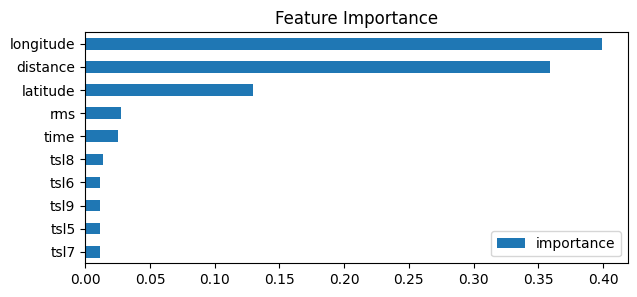

In [15]:
### displaying the model's predictions vs actual ###
y_pred = model.predict(X_test)
y_test_depth = y_test[:, 0]
y_test_mag = y_test[:, 1]
y_pred_depth = y_pred[:, 0]
y_pred_mag = y_pred[:, 1]
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# calculating the percentage of predictions that were within ±0.5 of the actual magnitude
total_mag = len(y_pred_mag)
correct_mag = 0
percent_mag_correct = 0.
for i in range(len(y_pred_mag)):
  if abs(y_pred_mag[i] - y_test_mag[i]) <= 0.5:
    correct_mag += 1

# calculating the percentage of predictions that were within ±50 km of the actual depth
total_depth = len(y_pred_depth)
correct_depth = 0
percent_depth_correct = 0.
for i in range(len(y_pred_depth)):
  if abs(y_pred_depth[i] - y_test_depth[i]) <= 100:
    correct_depth += 1

percent_mag_correct = correct_mag / total_mag
percent_depth_correct = correct_depth / total_depth

print(f'Percentage of predictions within ±0.5 of the actual magnitude: {percent_mag_correct}')
print(f'Percentage of predictions within ±100 km of the actual depth: {percent_depth_correct}')

# making the plot for depth
axes[0].scatter(y_test_depth, y_pred_depth, alpha=0.5, color='royalblue')
axes[0].plot([min(y_test_depth), max(y_test_depth)],
             [min(y_test_depth), max(y_test_depth)], 'r--')
axes[0].set_title('Depth Prediction vs Actual')
axes[0].set_xlabel('Actual Depth')
axes[0].set_ylabel('Predicted Depth')

# making the plot for magnitude
axes[1].scatter(y_test_mag, y_pred_mag, alpha=0.5, color='seagreen')
axes[1].plot([min(y_test_mag), max(y_test_mag)],
             [min(y_test_mag), max(y_test_mag)], 'r--')
axes[1].set_title('Magnitude Prediction vs Actual')
axes[1].set_xlabel('Actual Magnitude')
axes[1].set_ylabel('Predicted Magnitude')

plt.tight_layout()
plt.legend()
plt.show()


### evaluating which of the features contributed the most towards predicting the magnitude ###
fi = pd.DataFrame(
    data=model.feature_importances_,
    index=['time', 'latitude', 'longitude', 'tsl5', 'tsl6', 'tsl7', 'tsl8', 'tsl9', 'distance', 'rms'],
    columns=['importance']
)
fi.sort_values('importance').plot(figsize=(7, 3), kind='barh', title='Feature Importance')

# computing and graphing the loss of the model

# Make your own predictions! ***Work in Progress***
Here, you can input your own vector containing these following features: time, latitude, longitude. tsl5-tsl9 and distance from Ring of Fire will be calculated from these given inputs. rms (root-mean-square of the residuals of the earthquake's hypocenter location) will be defaulted to 0.

After giving it your input, the model will give you the depth and magnitude of the earthquake that it predicts to happen on that day at that location. In this, instead of the (X, y) set being split 80/20 into training and test sets, the entire (X, y) set is used as the "training" set, and you can then put in your own input in which it will make a prediction for

In [34]:
X = df.iloc[:, 0:10]
y = df.iloc[:, 10:]

# this is the same model architecture as the one defined 2 code cells above
modelfull = xgb.XGBRegressor(
    n_estimators=1000,
    #early_stopping_rounds=50,
    learning_rate=0.075,
    max_depth=4,
    reg_lambda=2,
    reg_alpha=0.5,
    gamma=1,
    min_child_weight=8,
)

modelfull.fit(X, y,
              verbose=100,
              eval_set=[(X, y)]
)

input = ("Enter the following parameters in the specified format, all separated by commas: date (YYYY-MM-DD), latitude (float), longitude (float) ")

[0]	validation_0-rmse:89.20064
[100]	validation_0-rmse:43.31355
[200]	validation_0-rmse:36.17185
[300]	validation_0-rmse:33.68672
[400]	validation_0-rmse:32.31570
[500]	validation_0-rmse:31.16250
[600]	validation_0-rmse:30.12469
[700]	validation_0-rmse:29.37436
[800]	validation_0-rmse:28.68584
[900]	validation_0-rmse:28.14880
[999]	validation_0-rmse:27.62929
